In [32]:
import pandas as pd
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from sklearn.linear_model import LinearRegression
from multiprocessing import Pool
from functools import partial
import sys
import warnings
import scipy
import warnings
import seaborn

In [3]:
#reading raw data
working_dir = ".."
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
data = raw_data[["sub", "condition", "cresp", "resp", "cor", "cj", "phase", "trial", "trial_rev","reward", "Lreward", "Hreward" ]]
chance_level_subs = [45634, 46069, 46279, 46303, 46651, 47398]
lv_induction_data = data[ (data["phase"] == "induction") &(data["condition"] == "hc") & (~data["sub"].isin(chance_level_subs))]
subjects = lv_induction_data["sub"].unique()


# Plotting Functions

In [87]:
def pval_symb(p):
  if p < 0.001:
    sig_symbol = '***'
  elif p < 0.01:
   sig_symbol = '**'
  elif p < 0.05:
   sig_symbol = '*'
  else:
   sig_symbol = "n.s" 
  return(sig_symbol)

def comparison_plot(df ,y_column, groups , color_dict, titlestr = "", s = [] ,y_list = [], h_list = [], legend = "", y_label = "", var_df = pd.DataFrame()):
  # plt.figure(figsize=(8,6))

  for gr1, gr2 in zip(groups[:-1], groups[1:]):
    X_coords= np.array([df.query("model=='{}'".format(gr1)).x_idx, 
                           df.query("model=='{}'".format(gr2)).x_idx])
    Y_coords= np.array([df.query("model=='{}'".format(gr1))[y_column], 
                           df.query("model=='{}'".format(gr2))[y_column]])
    plt.plot(X_coords, 
          Y_coords, 
          color='gray',
          alpha = .2)
    
    x_means = [df.query("model=='{}'".format(gr1)).x_idx.mean(), df.query("model=='{}'".format(gr2)).x_idx.mean()]
    y_means = [df.query("model=='{}'".format(gr1))[y_column].mean(), df.query("model=='{}'".format(gr2))[y_column].mean()]
    plt.plot(x_means, 
          y_means,
          marker='o',
          linewidth=3, markersize=10, color= "black")


  c = 0
  for gr1, gr2 in s:
    gr1_data = df.query("model=='{}'".format(gr1))
    gr2_data = df.query("model=='{}'".format(gr2))
    gr1_x_mean = gr1_data.x_idx.mean()
    gr2_x_mean = gr2_data.x_idx.mean()

    # stat, p = scipy.stats.ttest_ind(np.array(gr1_data[y_column]),np.array(gr2_data[y_column])).pvalue
    stat, p=  scipy.stats.wilcoxon(np.array(gr1_data[y_column]),np.array(gr2_data[y_column]))
    print('Statistics={}, p={}'.format(stat, p))
    symb = pval_symb(p)
    y = y_list[c]
    h = h_list[c]
    plt.plot([gr1_x_mean, gr1_x_mean, gr2_x_mean, gr2_x_mean], [y, y+h, y+h, y], lw=1.5, c="k")
    plt.text((gr1_x_mean+gr2_x_mean)/2, y+h, symb, ha='center', va='bottom', fontsize=16)
    c +=1 

  gr_xticks_ls = []  
  for gr in groups:
    plt.scatter(df.query("model=='{}'".format(gr)).x_idx, 
              df.query("model=='{}'".format(gr))[y_column],
            label = gr, c = color_dict[gr])
    gr_mean = df.query("model=='{}'".format(gr)).x_idx.mean()
    gr_xticks_ls.append(gr_mean)

  if not var_df.empty:
    for i,row in var_df.iterrows():
      line_pos = df[(df['subject'] == row["sub"])& (df['model'] == "Low-Meta") ]["x_idx"].iloc[0]
      line_mean = df[(df['subject'] == row["sub"])& (df['model'] == "Low-Meta") ][y_column].iloc[0]
      y_min = line_mean - row["cor"]
      y_max = line_mean +row["cor"]
      plt.vlines(x = line_pos, ymin = y_min, ymax = y_max, colors= "#fc5252", alpha= .2)
      plt.hlines(y = y_min, xmin= line_pos-1, xmax= line_pos + 1, colors= "#fc5252", alpha= .2)
      plt.hlines(y = y_max, xmin= line_pos-1, xmax= line_pos + 1, colors= "#fc5252", alpha= .2)
  

  plt.title(titlestr, fontsize = 12)
  plt.ylabel(y_label, fontsize=24)
  plt.yticks(fontsize=20)
  plt.xticks(fontsize=24 )
  ax = plt.gca()
  plt.xticks(gr_xticks_ls, groups)
  
  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

  #hide x-axis
  # ax.get_xaxis().set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  # ax.spines['bottom'].set_visible(False)

  if legend != "":
    ax.legend(loc = legend)
  else:
    ax.legend()


  # plt.show()



# Helper Functions

In [5]:
log_max_float = np.log(sys.float_info.max/2.1)

color_dict = {"Forward" : "blue", "‌‌Backward": "red", "Empirical": "green", "Low-Meta": "#fc5252", "High-Meta": "#c00505", "Backward_perfomance": "red" ,"MetaRL.Ratio": "green"}
color_dict_rgb = {"Low-Meta" : "#fcb0b0", "High-Meta": "#a20505"}
def mean_square_distance(subject_conf, model_conf):
  return np.mean((subject_conf- model_conf)**2)

def protected_log(x):

  'Return log of x protected against giving -inf for very small values of x.'
  
  return np.log(((1e-200)/2)+(1-(1e-200))*x)

def softmax_func(Q,beta):

  '''Array based calculation of softmax probabilities for binary choices.
  Q: Action values - array([n_trials,2])
  beta: Inverse temp  - float.'''
  P = np.zeros(2)

  try:
    # Code that may cause an overflow warning
    TdQ = -beta*(Q[0]-Q[1])
  except RuntimeWarning:
    # Code to handle the warning
    print(beta, Q[0], Q[1])
    TdQ = 0

  

  if TdQ > log_max_float:  # Protection against overflow in exponential.  
    TdQ = log_max_float

  P[0] = 1./(1. + np.exp(TdQ))

  P[1] = 1. - P[0]
  
  return P

def softmax_func_dQ(dQ,beta):

  '''Array based calculation of softmax probabilities for binary choices.
  Q: Action values - array([n_trials,2])
  beta: Inverse temp  - float.'''
  try:
    # Code that may cause an overflow warning
    TdQ = -beta*(dQ)
  except RuntimeWarning:
    # Code to handle the warning
    print(beta, Q[0], Q[1])
    TdQ = 0

  

  TdQ[TdQ >log_max_float] = log_max_float # Protection against overflow in exponential.    

  P = 1./(1. + np.exp(TdQ))
  
  return P



def linear_transform_on_array(input_array, domain_range, codomain_range):
  xl , xu = domain_range
  yl, yu = codomain_range
  if xl != xu:
    y = ((yu-yl)/(xu - xl))* (input_array -xl) + yl
  else:
    y = np.ones_like(input_array)*yl
  return y


def make_df_after_fitting(fitting_res, paramter_names, subjects):
  n_params = len(paramter_names)
  df_data = np.zeros((len(fitting_res), n_params + 3))
  df_names = []
  df_names.append("subject")
  for name in paramter_names:
    df_names.append(name)

  df_names.append("LL")
  df_names.append("Confindence Distance")
  count = 0

  for res in fitting_res:
    df_data[count, 0] = subjects[count] 
    fitted_param = res[0]
    for i in range(len(paramter_names)):
      df_data[count, i+1] = fitted_param[i]
    df_data[count, len(paramter_names)+1] = res[1][-1]
    df_data[count, len(paramter_names)+2] = res[2][-1]
    count += 1
  return pd.DataFrame(df_data, columns = df_names)

def get_task_info(data, subject):
  one_subject_data = data[data["sub"] == subject]
  rewards = np.array(one_subject_data["reward"])
  resps = np.array(one_subject_data["resp"])
  confs =  np.array(one_subject_data["cj"])
  return {"resps" : resps, "rewards": rewards, "confs": confs}

def get_agent_info(data, subject):
  one_subject_data = data[data["agent"] == subject]
  rewards = np.array(one_subject_data["reward"])
  resps = np.array(one_subject_data["resp"])
  confs =  np.array(one_subject_data["cj"])
  return {"resps" : resps, "rewards": rewards, "confs": confs}

def model_subj_conf_dist(params,confs, resp_probs):

    lbound = params[0]
    hbound = params[1]*(5 - lbound)  + lbound

    chosen_probs = resp_probs.copy()
    # chosen_probs[chosen_probs > hbound] = hbound
    # chosen_probs[chosen_probs < lbound] = lbound
    model_confs = linear_transform_on_array(chosen_probs, [0, 1], [lbound, hbound])
    return mean_square_distance(confs, model_confs)



def merge_reuslt_df (dataframes, lables, gap):
  subj_to_ind = {}
  subj_to_ind_low = {}
  idx = 1
  low_idx = 1
  for subject in subjects:
    subj_to_ind[subject] = idx
    subj_to_ind_low[subject] = low_idx
    idx +=1
    low_idx +=3

  count = 0
  for df, label in zip(dataframes, lables):
    df["model"] = label
    df["x_idx"] = df.apply(lambda x: subj_to_ind[x["subject"]] + count*gap, axis=1)
    # if label == "Low-Meta":
    #   df["x_idx"] = df.apply(lambda x: subj_to_ind_low[x["subject"]] + count*gap - 60, axis=1)
    # else:
    #   df["x_idx"] = df.apply(lambda x: subj_to_ind[x["subject"]] + count*gap, axis=1)
    count += 1
  return pd.concat(dataframes, ignore_index=True)


def get_subject_task(data, subject):
    one_subject_data = data[data["sub"] == subject]
    # extracting block rewards
    blocks = {}
    block_idx = 0
    block_trials = []
    for i,row in one_subject_data.iterrows(): 
        block_trials.append((row["cresp"],row["Lreward"]/100, row["Hreward"]/100, row["condition"]))
        if row["trial_rev"] == 0:
            blocks[block_idx] = block_trials
            block_idx = block_idx + 1
            block_trials = []
    trials_info = []
    for block, trials in blocks.items():
      trials_info.extend(trials)
    return trials_info

In [6]:
def group_brier(ser):
    cor = ser["cor"]
    c = linear_transform_on_array(ser["cj"], [1, 5], [0, 1])
    return np.mean(np.power(cor - c,2))
def group_qsr(ser):
    cor = ser["cor"]
    c = linear_transform_on_array(ser["cj"], [1, 5], [0, 1])
    return 1- np.mean(np.power(cor - c,2))

def group_brier_scaled(b, cor, conf):
    lb= b[0]
    hb = b[1]*(1 - lb) + lb
    c = linear_transform_on_array(conf, [1, 5], [lb, hb])
    return np.mean(np.power(cor - c,2))

# Simulation Functions

In [7]:
def simulate_basic_q_agent(params, trials_info): 
    
    alpha = params[0]
    beta = params[1]

    lbound = params[2]
    hbound = params[3]

    Q = np.array([0.5, 0.5])
    Q_list= np.zeros((len(trials_info), 2))
    rewards = []
    resps = []
    chosen_probs = np.zeros(len(trials_info))
    
    acc = np.zeros(len(trials_info))
    for t,trial in enumerate(trials_info):
        Q_list[t,:] = Q
        correct_resp = trial[0]
        low_reward = trial[1]
        high_reward = trial[2]
        choices_probability = softmax_func(Q, beta)
        resp = np.random.choice([0, 1], p =choices_probability)
        chosen_probs[t] = choices_probability[resp]
        if resp == correct_resp:
            reward = high_reward
            acc[t] = 1
        else :
            acc[t] = 0
            reward = low_reward
        resps.append(resp)
        rewards.append(reward)
        prediction_error = reward - Q[resp]
        Q[resps[t]] = Q[resps[t]] + alpha * prediction_error
            
    confs = linear_transform_on_array(chosen_probs, [0, 1], [lbound, hbound])
    return resps, rewards, acc, confs, Q_list

In [8]:
def simulate_with_params(params_df, data,subjects):
  df_lists = []
  for i,row in params_df.iterrows():
    params = [row["alpha"], row["beta"], row["lbound"], row["hbound"]]
    subject = int(row["subject"])
    trials_info = get_subject_task(data, subject)
    resps, rewards, acc, confs, Q_list = simulate_basic_q_agent(params, trials_info)
    subject_list = [subject]*(len(resps)) 
    df = pd.DataFrame(zip(subject_list, resps, rewards, acc, confs, Q_list[:,0], Q_list[:,1]), columns= ["sub","resp", "reward", "cor","cj", "Q1", "Q2"])
    df_lists.append(df)
  return pd.concat(df_lists, axis=0, ignore_index=True)


# Likelihood Functions


## forward model

In [9]:
def forward_LL(params, resps,rewards, *args):
    alpha = params[0]
    beta = params[1]
    task_length = len(resps)
    resps_probabilities = np.zeros(task_length)
    Q = np.array([.5, .5]) 
    change_experiment = np.array([400, 800, 1199])
    for t in range(task_length):
        choices_probability = softmax_func(Q, beta)
        resps_probabilities[t] = choices_probability[resps[t]]
        prediction_error = rewards[t] - Q[resps[t]]
        Q[resps[t]] = Q[resps[t]] + alpha * prediction_error

    neg_LL = -np.sum(protected_log(resps_probabilities));
    return neg_LL


In [10]:
def forward_probs(params, resps,rewards, *args):
   
    alpha = params[0]
    beta = params[1]

    task_length = len(resps)
    resps_probabilities = np.zeros(task_length)
    Q = np.array([.5, .5]) 
    change_experiment = np.array([400, 800, 1199])

    for t in range(task_length):
        if t in change_experiment:
          Q = np.array([0.5, 0.5])
        choices_probability = softmax_func(Q, beta)
        resps_probabilities[t] = choices_probability[resps[t]]
        prediction_error = rewards[t] - Q[resps[t]]
        Q[resps[t]] = Q[resps[t]] + alpha * prediction_error

    return resps_probabilities


## backward model

In [11]:
def backward_distance(params, resps,rewards, confs):
    alpha = params[0]
    beta = params[1]

    lbound = params[2]
    hbound = params[3]*(5 - lbound) + lbound

    task_length = len(resps)
    resps_probabilities = np.zeros(task_length)
    Q = np.array([.5, .5]) 
    for t in range(task_length):
        choices_probability = softmax_func(Q, beta)
        resps_probabilities[t] = choices_probability[resps[t]]
        prediction_error = rewards[t] - Q[resps[t]]
        Q[resps[t]] = Q[resps[t]] + alpha * prediction_error

    model_confs = linear_transform_on_array(resps_probabilities, [0, 1], [lbound, hbound])
    dist = mean_square_distance(confs, model_confs)
    return dist

# Fitting Helper Functions

In [12]:
def fit_for_all_subjects(params_ranges,n_fitting,subjects, data, fitting_func):
  input_dict = [get_task_info(data, sub) for sub in subjects]
  for d in input_dict:
    d["n_fitting"] = n_fitting
    d["params_ranges"] = params_ranges

  with Pool(60) as p:
    result = p.map(fitting_func, input_dict)
  return result


In [13]:
def fit_brier(subjects, data):
  input_dict = []

  for sub in subjects:
    one_subject_data = data[data["sub"] == sub]
    cor = np.array(one_subject_data["cor"])
    confs =  np.array(one_subject_data["cj"])
    input_dict.append({"cor" : cor, "confs": confs})

  with Pool(60) as p:
    result = p.map(minimize_brier, input_dict)
  return result


In [14]:
def fit_for_all_agents(params_ranges,n_fitting, agents, data, fitting_func):
  input_dict = [get_agent_info(data, sub) for sub in agents]
  for d in input_dict:
    d["n_fitting"] = n_fitting
    d["params_ranges"] = params_ranges

  with Pool(60) as p:
    result = p.map(fitting_func, input_dict)
  return result


In [15]:
def fit_for_one_subject(params_ranges,n_fitting, agent, data, fitting_func):
  d = get_task_info(data, agent)
  d["n_fitting"] = n_fitting
  d["params_ranges"] = params_ranges
  result = fitting_func(d)
  return [result]


## Forward Models

In [16]:
def forward_fitting(dict_input):
  resps = dict_input["resps"]
  rewards = dict_input["rewards"]
  confs = dict_input["confs"]
  n_fitting = dict_input["n_fitting"]
  params_ranges = dict_input["params_ranges"]
  model_param_ranges = params_ranges[:2]
  bound_ranges = params_ranges[2:]
  min_neg_LL = np.inf
  neg_LL_seq = np.zeros(n_fitting)
  for j in range(n_fitting):
    params0 = np.zeros(len(model_param_ranges))
    for p in range(len(model_param_ranges)):
      params0[p] = (np.random.uniform(*model_param_ranges[p]))
    fitting_result = minimize(forward_LL,x0= params0, args=(resps, rewards), bounds=model_param_ranges)
    if fitting_result.success:
      if fitting_result.fun < min_neg_LL:
        min_neg_LL = fitting_result.fun
        fit_res = fitting_result.x
    neg_LL_seq[j] = min_neg_LL

  alpha, beta = fit_res

  min_dist = np.inf
  dist_seq = np.zeros(n_fitting)
  
  resp_probs = forward_probs(fit_res, resps,rewards)

  for j in range(n_fitting):
    params0 = np.zeros(len(bound_ranges))
    for p in range(len(bound_ranges)):
      params0[p] = (np.random.uniform(*bound_ranges[p]))
    fitting_result = minimize(model_subj_conf_dist, x0= params0, args=(confs, resp_probs), bounds=bound_ranges)
    if fitting_result.success:
      if fitting_result.fun < min_dist:
        min_dist = fitting_result.fun
        fit_res = fitting_result.x
    dist_seq[j] = min_dist

  lbound, bound_range = fit_res
  fit_res = (alpha, beta, lbound, bound_range)

  return fit_res, neg_LL_seq, dist_seq

## Backward models

In [17]:
def backward_fitting(dict_input):
  resps = dict_input["resps"]
  rewards = dict_input["rewards"]
  confs = dict_input["confs"]
  n_fitting = dict_input["n_fitting"]
  params_ranges = dict_input["params_ranges"]
  min_dist = np.inf
  neg_LL = 0
  dist_seq = np.zeros(n_fitting)
  neg_LL_seq = np.zeros(n_fitting)
  for j in range(n_fitting):
    params0 = np.zeros(len(params_ranges))
    for p in range(len(params_ranges)):
      params0[p] = (np.random.uniform(*params_ranges[p]))
    fitting_result = minimize(backward_distance,x0= params0, args=(resps, rewards, confs), bounds=params_ranges)
    if fitting_result.success:
      if fitting_result.fun < min_dist:
        min_dist = fitting_result.fun
        fit_res = fitting_result.x
        neg_LL = forward_LL(fit_res, resps,rewards)
    dist_seq[j] = min_dist
    neg_LL_seq[j] = neg_LL
  return fit_res, neg_LL_seq,dist_seq


In [18]:
def minimize_brier(dict_input):
    confs = dict_input["confs"]
    cors = dict_input["cor"]
    n_fitting = 60 
    min_brier = np.inf
    model_param_ranges = [[0,1], [0,1]]
    for j in range(n_fitting):
      params0 = np.zeros(len(model_param_ranges))
    for p in range(len(model_param_ranges)):
      params0[p] = (np.random.uniform(*model_param_ranges[p]))
    fitting_result = minimize(group_brier_scaled,x0= params0, args=(cors, confs), bounds=model_param_ranges)
    if fitting_result.success:
      if fitting_result.fun < min_brier:
        min_brier = fitting_result.fun
        fit_res = fitting_result.x
    return fit_res, min_brier

# Fitting Results

## forward model

In [79]:
params_ranges = [[0, 1], [0, 100], [1,5], [0, 1]]
n_fitting = 120
res = fit_for_all_subjects(params_ranges,n_fitting,subjects, lv_induction_data, forward_fitting)
forward_df = make_df_after_fitting(res, ["alpha", "beta", "lbound", "bound_range"], subjects)
forward_df["hbound"] = (5 - forward_df["lbound"])*(forward_df["bound_range"]) + forward_df["lbound"]

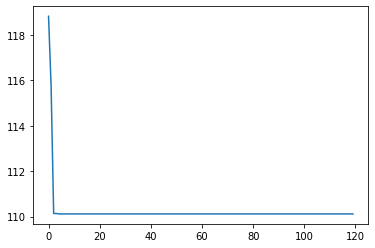

In [80]:
min_nlls = np.zeros((len(subjects),n_fitting))
for i,r in enumerate(res):
  min_nlls[i,:] = r[1]

plt.plot(np.mean(min_nlls, axis=0))
plt.show()

## backward model 

In [81]:
params_ranges = [[0, 1], [0, 100], [1,5], [0.001, 1]]
n_fitting = 120
back_res = fit_for_all_subjects(params_ranges,n_fitting,subjects, lv_induction_data, backward_fitting)
backward_df = make_df_after_fitting(back_res, ["alpha", "beta", "lbound", "bound_range"], subjects)
backward_df["hbound"] = (5 - backward_df["lbound"])*(backward_df["bound_range"]) + backward_df["lbound"]

In [82]:
backward_df

,subject,alpha,beta,lbound,bound_range,LL,Confindence Distance,hbound
0,45628.0,1.000000,13.260669,4.606821,0.221287,139.034618,0.774456,4.693826
1,45640.0,0.003908,100.000000,3.968331,1.000000,275.681213,0.410537,5.000000
2,45664.0,0.001108,100.000000,1.270128,1.000000,275.198522,1.536389,5.000000
3,45682.0,0.658564,57.058181,2.026064,0.693936,453.478998,0.705934,4.089785
4,45745.0,1.000000,7.876816,4.041896,1.000000,190.566009,0.437457,5.000000
5,45760.0,0.747970,23.764477,1.000000,0.927304,82.892271,0.533329,4.709216
6,45763.0,0.900032,11.528015,2.346942,0.937333,69.632259,0.950495,4.833740
7,45805.0,0.945853,5.262046,4.643276,1.000000,212.436692,0.245864,5.000000
8,45829.0,1.000000,14.589950,1.331203,0.832861,112.315227,0.742902,4.386802
9,45964.0,0.486703,29.946119,1.794287,0.765650,164.947383,0.772505,4.248742


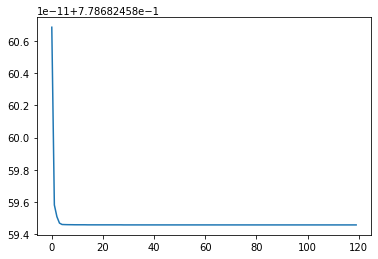

In [22]:
min_nlls = np.zeros((len(subjects),n_fitting))
for i,r in enumerate(res):
  min_nlls[i,:] = r[2]

plt.plot(np.mean(min_nlls, axis=0))
plt.show()

In [23]:
brier_res = fit_brier(subjects, lv_induction_data)
scaled_brier_ls = []
for res in brier_res:
  scaled_brier_ls.append(res[1])

scaled_brier_df = pd.DataFrame(list(zip(subjects, scaled_brier_ls)),
               columns =['subject', 'brier'])
scaled_brier_df["QSR"] = 1 - scaled_brier_df["brier"]

In [84]:
forward_df.to_csv(working_dir + "forward_basic.csv", index= False)
backward_df.to_csv(working_dir + "backward_basic.csv", index= False)

## compare fitted parameters 

Statistics=27.0, p=4.717290906942734e-08
Statistics=533.0, p=0.07125628805900129


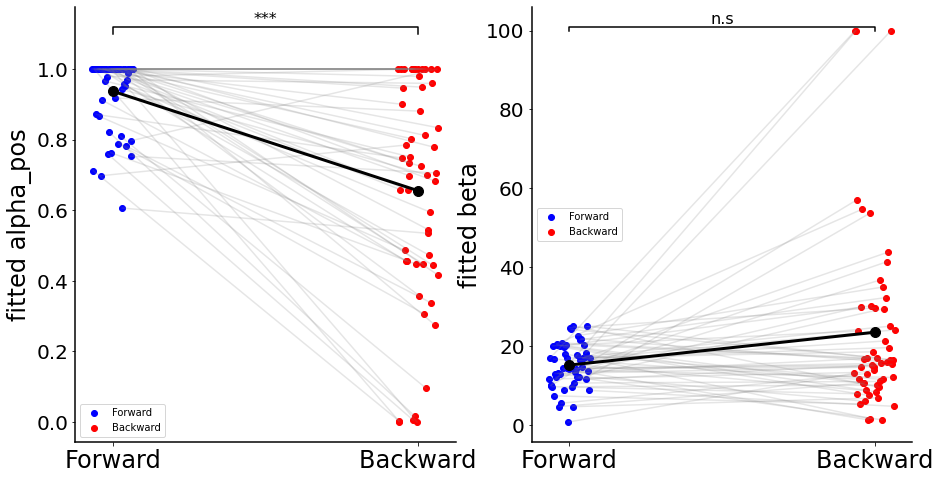

In [88]:
groups = ["Forward","‌‌Backward"]
df = merge_reuslt_df([forward_df, backward_df], groups, 400)
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
comparison_plot(df ,"alpha", groups, color_dict, "", [["Forward", "‌‌Backward"]], [1.1], [.02], y_label= "fitted alpha_pos")
plt.subplot(1, 2, 2)
comparison_plot(df ,"beta", groups, color_dict, "", [["Forward", "‌‌Backward"]], [100], [1], y_label= "fitted beta")


Statistics=350.0, p=0.014644313163864933
Statistics=333.0, p=0.0004220713662241401


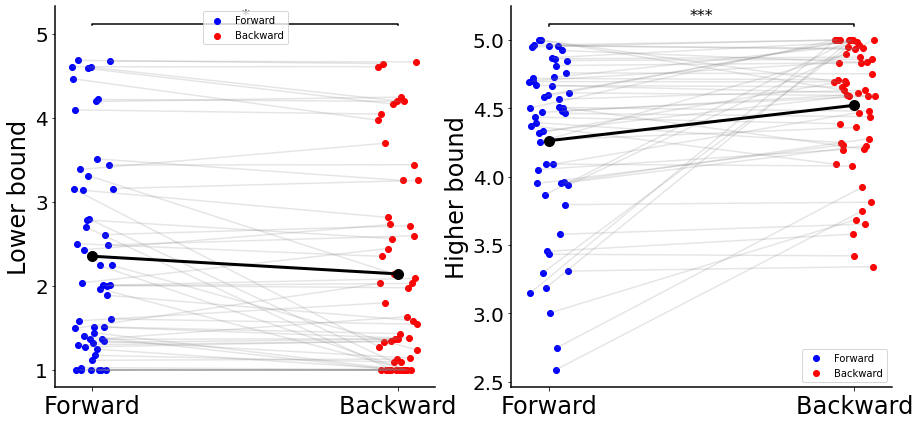

In [89]:
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
comparison_plot(df ,"lbound", groups, color_dict, "", [["Forward", "‌‌Backward"]], [5.1], [.02], y_label= "Lower bound")
plt.subplot(1, 2, 2)
comparison_plot(df ,"hbound", groups, color_dict, "", [["Forward", "‌‌Backward"]], [5.1], [.02], y_label= "Higher bound")


In [90]:
df["Bound_Range"]= df["hbound"] - df["lbound"]

Statistics=382.0, p=0.0019093392210631824


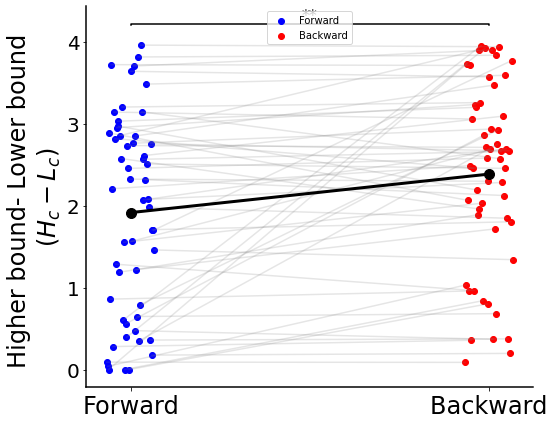

In [91]:
plt.figure(figsize=(8,7))
groups = ["Forward","‌‌Backward"]
comparison_plot(df ,"Bound_Range", groups, color_dict, "", [["Forward", "‌‌Backward"]], [4.2], [.02], y_label = 'Higher bound- Lower bound \n' + r'$(H_c - L_c$)')
plt.savefig("fig11.png", dpi = 400)

Statistics=0.0, p=1.6256984569330967e-10


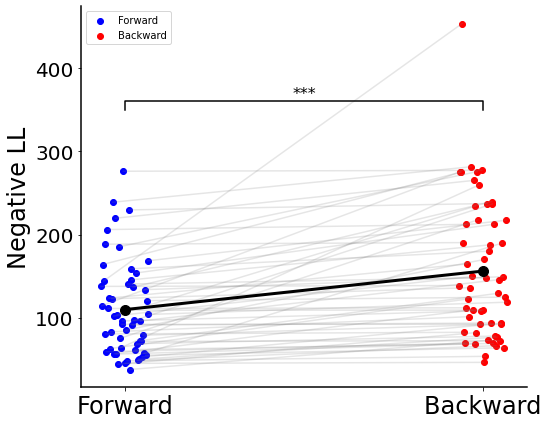

In [92]:
plt.figure(figsize=(8,7))
# plt.subplot(1, 2, 1)
comparison_plot(df ,"LL", groups, color_dict, "",[["Forward", "‌‌Backward"]], [350], [10],y_label="Negative LL")
# plt.subplot(1, 2, 2)
# comparison_plot(df ,"Confindence Distance", groups, color_dict, "",[["Forward", "‌‌Backward"]], [2.1], [.02], "lower center", "Confindence Distance")


Statistics=1.0, p=1.7198462727875601e-10


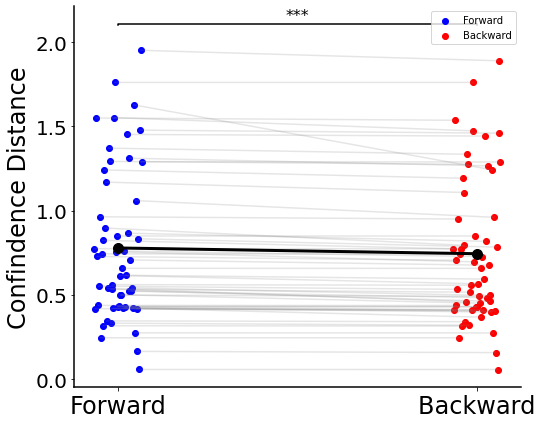

In [93]:
plt.figure(figsize=(8,7))
# plt.subplot(1, 2, 1)
comparison_plot(df ,"Confindence Distance", groups, color_dict, "",[["Forward", "‌‌Backward"]], [2.1], [.01],y_label="Confindence Distance", legend = "upper right")


In [95]:
backward_df["Confindence Distance"] < forward_df["Confindence Distance"]

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25    False
26     True
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35     True
36     True
37     True
38     True
39     True
40     True
41     True
42     True
43     True
44     True
45     True
46     True
47     True
48     True
49     True
50     True
51     True
52     True
53     True
Name: Confindence Distance, dtype: bool

# Simulation Results with fitted parameters

In [30]:
np.random.seed(1)
forward_simulation_df = simulate_with_params(forward_df, lv_induction_data,subjects)
backward_simulation_df = simulate_with_params(backward_df, lv_induction_data,subjects)
forward_simulation_df.rename(columns={"sub": "subject"}, inplace= True)
backward_simulation_df.rename(columns={"sub": "subject"}, inplace= True)
human_lv_df = lv_induction_data.rename(columns={"sub": "subject"})

In [31]:

# mean_reward, accuracy, mean_conf, brier, metai
subjects_avg_df = human_lv_df.groupby("subject").agg({ 'reward':'mean', 
                         'cor':'mean', 'cj': "mean"}).reset_index()
forward_avg_df = forward_simulation_df.groupby("subject").agg({ 'reward':'mean', 
                         'cor':'mean', 'cj': "mean"}).reset_index()
backward_avg_df = backward_simulation_df.groupby("subject").agg({ 'reward':'mean', 
                         'cor':'mean', 'cj': "mean"}).reset_index()
groups = ["Forward" ,"Empirical", "‌‌Backward"]

avg_df = merge_reuslt_df([forward_avg_df, subjects_avg_df,backward_avg_df ], groups, 200)
avg_df.rename(columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"}, inplace= True)

Statistics=18.0, p=4.423367868858516e-10
Statistics=25.0, p=6.478807916162032e-10
Statistics=185.0, p=2.636966511773785e-06


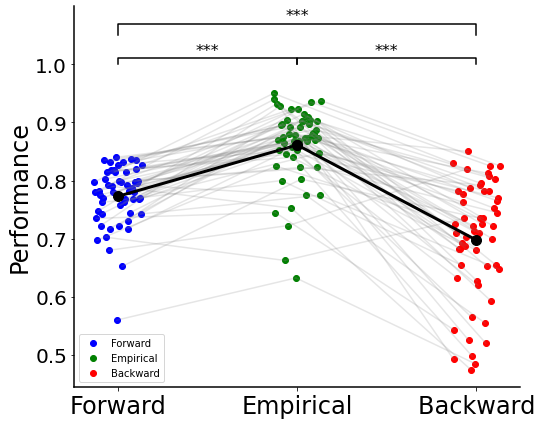

In [32]:
plt.figure(figsize=(8,7))
# plt.subplot(1, 2, 1)
# comparison_plot(avg_df ,"mean_reward", groups, color_dict, "Mean Collected Reward",[["human", "backward"],["human", "forward"] ,["forward", "backward"]], [.60, .60, .61], [.002,.002, .004])
# plt.subplot(1, 2, 2)
comparison_plot(avg_df ,"accuracy", groups, color_dict, "",[["‌‌Backward", "Empirical"],["Empirical", "Forward"] ,["Forward", "‌‌Backward"]], [1, 1, 1.05], [.01, .01 , .02], y_label= "Performance")
# plt.subplot(1, 2, 2)
# comparison_plot(avg_df ,"mean conf", groups, color_dict, "",[["human", "backward"],["human", "forward"] ,["forward", "backward"]], [5.1, 5.1, 5.4], [.1,.1, .1], legend= "lower right", y_label="Average Confidence")
plt.savefig("fig4.png", dpi = 400)

Statistics=586.0, p=0.1778195377871742
Statistics=598.0, p=0.21343461052333657
Statistics=664.0, p=0.49910279625251475


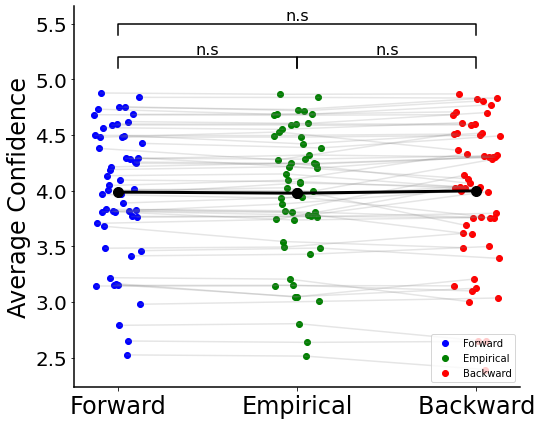

In [33]:
plt.figure(figsize=(8,7))

comparison_plot(avg_df ,"mean conf", groups, color_dict, "",[["‌‌Backward", "Empirical"],["Empirical", "Forward"] ,["Forward", "‌‌Backward"]], [5.1, 5.1, 5.4], [.1,.1, .1], legend= "lower right", y_label="Average Confidence")


Statistics=0.0, p=1.6256984569330967e-10


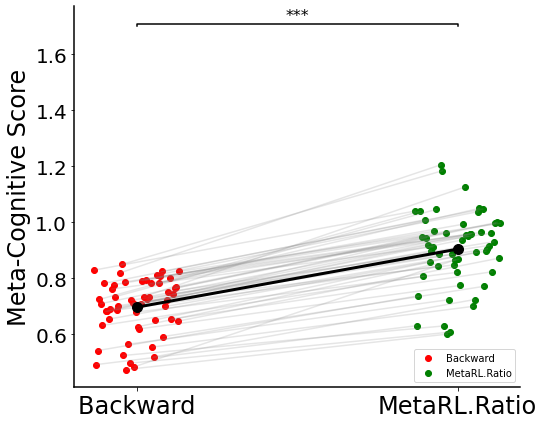

In [34]:
plt.figure(figsize=(8,7))

mrl_df = forward_avg_df.copy()
mrl_df["cor"] = backward_avg_df["cor"] / forward_avg_df["cor"]
groups = ["‌‌Backward" ,"MetaRL.Ratio"]

measure_compare_df = merge_reuslt_df([backward_avg_df, mrl_df ], groups, 200)
comparison_plot(measure_compare_df ,"cor", groups, color_dict, "",[groups], [1.7], [.01], y_label= "Meta-Cognitive Score")
plt.savefig("fig10.png", dpi = 400)


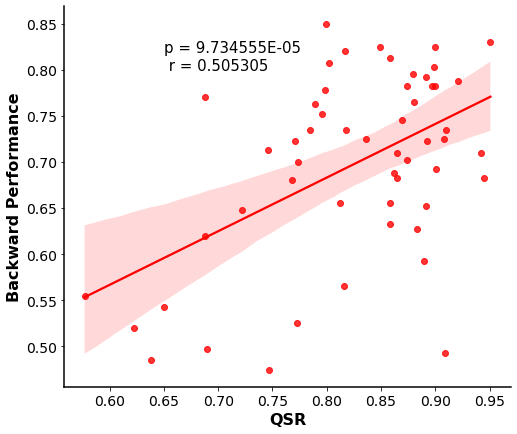

In [36]:
plt.figure(figsize=(8,7))
emp_qsr_df = lv_induction_data.groupby("sub").apply(group_qsr).reset_index().rename(columns={0: "QSR", "sub": "subject"})
backward_emp_qsr = pd.merge(backward_avg_df, emp_qsr_df, on=['subject'])
forward_emp_qsr = pd.merge(forward_avg_df, emp_qsr_df, on=['subject'])
backward_emp_qsr["forward_cor"] = forward_emp_qsr["cor"]
backward_emp_qsr["backward/forward"] = backward_emp_qsr["cor"]/backward_emp_qsr["forward_cor"]


seaborn.regplot(data = backward_emp_qsr, x = "QSR", y = "cor", label= "Backward Performance", color= "red")

stat,pval = scipy.stats.pearsonr(backward_emp_qsr["QSR"], backward_emp_qsr["cor"])

plt.ylabel("Backward Performance", fontsize = 16, fontweight = "bold")
plt.xlabel("QSR", fontsize = 16, fontweight = "bold")

ax = plt.gca()
#hide x-axis
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(.65, .8, "p = {:E} \n r = {:f}".format(pval, stat), fontsize=15)

plt.savefig("fig3.png", dpi = 400)

plt.show()

In [37]:
",".join(str(e) for e in backward_emp_qsr["cor"])

'0.83,0.4925,0.5425,0.725,0.71,0.6325,0.7825,0.6825,0.6825,0.655,0.6925,0.7625,0.7775,0.735,0.6875,0.7025,0.82,0.85,0.525,0.7875,0.475,0.565,0.4975,0.7225,0.7125,0.485,0.68,0.6275,0.62,0.71,0.7925,0.735,0.795,0.725,0.735,0.7825,0.555,0.52,0.6525,0.8125,0.7825,0.8075,0.825,0.5925,0.7,0.7225,0.7525,0.8025,0.655,0.745,0.765,0.77,0.6475,0.825'

Text(0.5, 0, 'QSR')

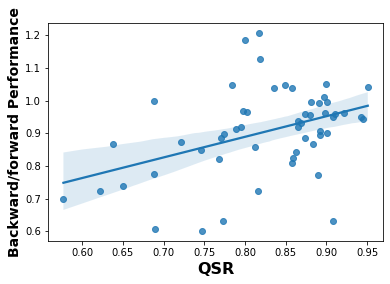

In [38]:
backward_emp_qsr = backward_emp_qsr.rename(columns= {"cor": "backward_cor"})
perf_qsr_df = pd.merge(backward_emp_qsr, forward_avg_df, on=['subject'])
perf_qsr_df["perf"] = perf_qsr_df["backward_cor"]/perf_qsr_df["cor"]

seaborn.regplot(data = perf_qsr_df, x = "QSR", y = "perf")

plt.ylabel("Backward/forward Performance", fontsize = 14, fontweight = "bold")
plt.xlabel("QSR", fontsize = 16, fontweight = "bold")


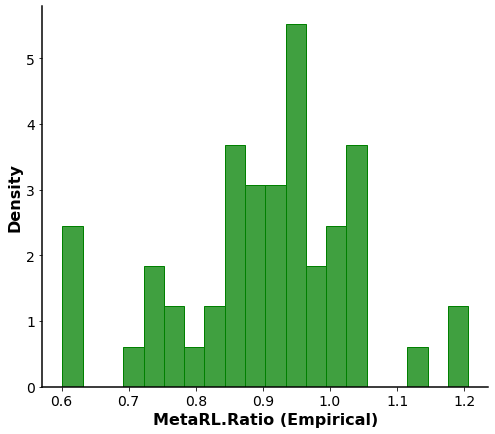

In [39]:
plt.figure(figsize=(8,7))

seaborn.histplot(data = perf_qsr_df, x= "perf", color= "green", stat="density", bins= 20, edgecolor= "green")

plt.ylabel("Density", fontsize = 16, fontweight = "bold")
plt.xlabel("MetaRL.Ratio (Empirical)", fontsize = 16, fontweight = "bold")

ax = plt.gca()
#hide x-axis
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig("fig5.png", dpi = 400)

plt.show()

# Fake Agents 2

In [46]:
high_syn_df = lv_induction_data.copy()
high_syn_df['cj'] = np.where(high_syn_df['cor']== 1, 5, 1)
low_syn_df = lv_induction_data.copy()
low_syn_df['cj']= np.random.uniform(1,5, len(high_syn_df))
human_bs = lv_induction_data.groupby("sub").apply(group_brier).reset_index().rename(columns={0: "Brier Score", "sub": "subject"})


Statistics=25.0, p=6.498805474855473e-10
Statistics=0.0, p=1.6256984569330967e-10
Statistics=0.0, p=1.6256984569330967e-10


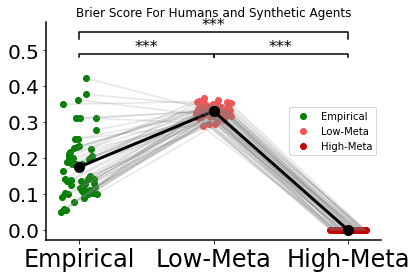

In [47]:
groups = ["Empirical", "Low-Meta","High-Meta"]

hm_syn_bs = high_syn_df.groupby("sub").apply(group_brier).reset_index().rename(columns={0: "Brier Score", "sub": "subject"})
lm_syn_bs = low_syn_df.groupby("sub").apply(group_brier).reset_index().rename(columns={0: "Brier Score", "sub": "subject"})
bs_df = merge_reuslt_df([human_bs, lm_syn_bs,hm_syn_bs], groups, 200)

comparison_plot(bs_df ,"Brier Score", groups, color_dict, "Brier Score For Humans and Synthetic Agents",[ ["Empirical", "Low-Meta"], ["Low-Meta", "High-Meta"], ["Empirical", "High-Meta"]], [.48, .48, .53], [.01, .01 , .02])


## Fit to Bakcward and Forward Models

In [50]:
params_ranges = [[0, 1], [0, 100], [1,5], [0, 1]]
n_fitting = 120
res = fit_for_all_subjects(params_ranges,n_fitting,subjects, high_syn_df, forward_fitting)
hsyn_forward_df = make_df_after_fitting(res, ["alpha", "beta", "lbound", "bound_range"], subjects)
hsyn_forward_df["hbound"] = (5 - hsyn_forward_df["lbound"])*(hsyn_forward_df["bound_range"]) + hsyn_forward_df["lbound"]

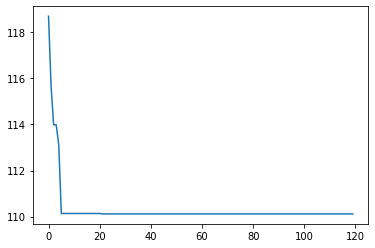

In [51]:
min_nlls = np.zeros((len(subjects),n_fitting))
for i,r in enumerate(res):
  min_nlls[i,:] = r[1]

plt.plot(np.mean(min_nlls, axis=0))
plt.show()

In [52]:
params_ranges = [[0, 1], [0, 100], [1,5], [0, 1]]
n_fitting = 120
res = fit_for_all_subjects(params_ranges,n_fitting,subjects, high_syn_df, backward_fitting)
hsyn_backward_df =  make_df_after_fitting(res, ["alpha", "beta", "lbound", "bound_range"], subjects)
hsyn_backward_df["hbound"] = (5 - hsyn_backward_df["lbound"])*(hsyn_backward_df["bound_range"]) + hsyn_backward_df["lbound"]

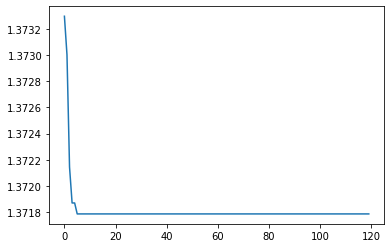

In [53]:
min_nlls = np.zeros((len(subjects),n_fitting))
for i,r in enumerate(res):
  min_nlls[i,:] = r[2]

plt.plot(np.mean(min_nlls, axis=0))
plt.show()

In [54]:
params_ranges = [[0, 1], [0, 100], [1,5], [0, 1]]
n_fitting = 120
res = fit_for_all_subjects(params_ranges,n_fitting,subjects, low_syn_df, backward_fitting)
lsyn_backward_df = make_df_after_fitting(res, ["alpha", "beta", "lbound", "bound_range"], subjects)
lsyn_backward_df["hbound"] = (5 - lsyn_backward_df["lbound"])*(lsyn_backward_df["bound_range"]) + lsyn_backward_df["lbound"]

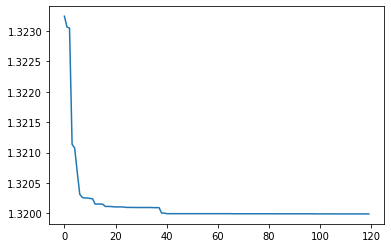

In [55]:
min_nlls = np.zeros((len(subjects),n_fitting))
for i,r in enumerate(res):
  min_nlls[i,:] = r[2]

plt.plot(np.mean(min_nlls, axis=0))
plt.show()

In [56]:
df_lists= []
count = 0
for i in range(30):
  low_syn_df['cj']= np.random.uniform(1,5, len(high_syn_df))
  params_ranges = [[0, 1], [0, 100], [1,5], [0, 1]]
  n_fitting = 50
  res = fit_for_all_subjects(params_ranges,n_fitting,subjects, low_syn_df, backward_fitting)
  lsyn_backward_df =  make_df_after_fitting(res, ["alpha", "beta", "lbound", "bound_range"], subjects)
  lsyn_backward_df["hbound"] = (5 - lsyn_backward_df["lbound"])*(lsyn_backward_df["bound_range"]) + lsyn_backward_df["lbound"]
  lsyn_backward_simulation_df = simulate_with_params(lsyn_backward_df, lv_induction_data,subjects)
  lsyn_backward_simulation_df["agent_nr"] = count
  df_lists.append(lsyn_backward_simulation_df)
  count +=1 

In [57]:
lsyn_backward_simulation_df = pd.concat(df_lists, axis=0, ignore_index=True)

In [58]:
var_df = lsyn_backward_simulation_df.groupby(['sub', 'agent_nr']).agg({'cor': 'mean'}).reset_index().groupby(["sub"])['cor'].apply(scipy.stats.sem).reset_index()

Statistics=1.0, p=1.7195138587965284e-10
Statistics=13.0, p=3.360689733093462e-10
Statistics=521.5, p=0.057039490673669146


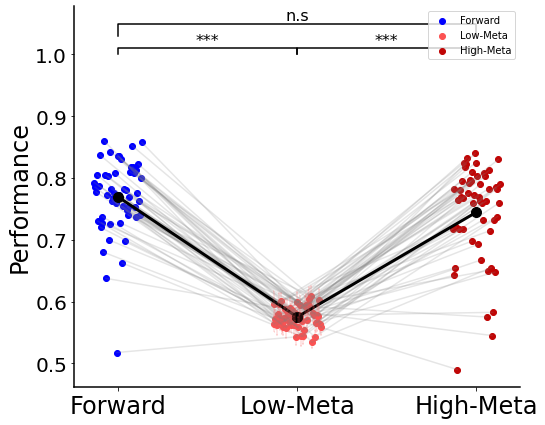

In [64]:
hsyn_backward_simulation_df = simulate_with_params(hsyn_backward_df, lv_induction_data,subjects)
# lsyn_backward_simulation_df = simulate_with_params(lsyn_backward_df, lv_induction_data,subjects)
hsyn_forward_simulation_df = simulate_with_params(hsyn_forward_df, lv_induction_data,subjects)

groups = ["Forward", "Low-Meta","High-Meta"]

fwd_avg_df = hsyn_forward_simulation_df.rename(columns={"sub": "subject"}).groupby("subject").agg({ 'reward':'mean', 
                         'cor':'mean', 'cj': "mean"}).reset_index()

hm_avg_df = hsyn_backward_simulation_df.rename(columns={"sub": "subject"}).groupby("subject").agg({ 'reward':'mean', 
                         'cor':'mean', 'cj': "mean"}).reset_index()
lm_avg_df = lsyn_backward_simulation_df.rename(columns={"sub": "subject"}).groupby("subject").agg({ 'reward':'mean', 
                         'cor':'mean', 'cj': "mean"}).reset_index()
avg_df = merge_reuslt_df([fwd_avg_df ,lm_avg_df,hm_avg_df ], groups, 200)
avg_df.rename(columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"}, inplace= True)

plt.figure(figsize=(8,7))
# plt.subplot(1, 2, 1)
# comparison_plot(avg_df ,"mean_reward", groups, color_dict, "Mean Collected Reward",[["forward", "high-meta"] ,["high-meta", "low-meta"]], [.60, .60, .61], [.002,.002, .004])
# plt.subplot(1, 2, 2)
comparison_plot(avg_df ,"accuracy", groups, color_dict, "",[["Forward", "Low-Meta"], ["Low-Meta", "High-Meta"],["Forward", "High-Meta"]], [1, 1, 1.03], [.01, .01 , .02], y_label="Performance", legend= "upper right", var_df= var_df)
plt.savefig("fig1.png", dpi = 400)

# Adding Noise to Agents

In [20]:
subject_id = subjects[12]
selected_sub_data = lv_induction_data[lv_induction_data['sub'] == subject_id]
high_syn_df = selected_sub_data.copy()
high_syn_df['cj'] = np.where(high_syn_df['cor']== 1, 5, 1)

params_ranges = [[0, 1], [0, 100], [1,5], [0, 1]]
n_fitting = 50
res = fit_for_all_subjects(params_ranges,n_fitting,[subject_id], high_syn_df, forward_fitting)
hsyn_forward_df = make_df_after_fitting(res, ["alpha", "beta", "lbound", "bound_range"], subjects)
hsyn_forward_df["hbound"] = (5 - hsyn_forward_df["lbound"])*(hsyn_forward_df["bound_range"]) + hsyn_forward_df["lbound"]

res = fit_for_all_subjects(params_ranges,n_fitting,[subject_id], high_syn_df, backward_fitting)
hsyn_backward_df = make_df_after_fitting(res, ["alpha", "beta", "lbound", "bound_range"], subjects)
hsyn_backward_df["hbound"] = (5 - hsyn_backward_df["lbound"])*(hsyn_backward_df["bound_range"]) + hsyn_backward_df["lbound"]


In [21]:
subject_id

46072

In [ ]:
hsyn_backward_simulation_df = simulate_with_params(hsyn_backward_df, lv_induction_data,[subject_id])
hsyn_forward_simulation_df = simulate_with_params(hsyn_forward_df, lv_induction_data,[subject_id])


In [ ]:
n_reps = 6
lsyn_backward_mean = 0
for i in range(n_reps):
  low_syn_df = selected_sub_data.copy()
  low_syn_df['cj']= np.random.uniform(1,5, len(high_syn_df))
  res = fit_for_all_subjects(params_ranges,n_fitting,[subject_id], low_syn_df, backward_fitting)
  lsyn_backward_df = make_df_after_fitting(res, ["alpha_pos", "alpha_neg", "alpha_unchosen", "beta", "lbound", "bound_range"], subjects)
  lsyn_backward_df["hbound"] = (5 - lsyn_backward_df["lbound"])*(lsyn_backward_df["bound_range"]) + lsyn_backward_df["lbound"]
  lsyn_backward_simulation_df = simulate_with_params(lsyn_backward_df, lv_induction_data,[subject_id])
  lsyn_backward_mean += lsyn_backward_simulation_df['cor'].mean()/n_reps

In [ ]:
print(hsyn_backward_simulation_df['cor'].mean())
print(hsyn_forward_simulation_df['cor'].mean())

In [25]:
def calculate_metai(data):
    data["cj_binned"] = pd.cut(data["cj"], bins=4, labels=False)
    P_rc = data.groupby(["cj_binned","cor"]).count()["trial"]/len(data)
    P_r = data.groupby("cor").count()["trial"]/len(data)
    P_c = data.groupby("cj_binned").count()["trial"]/len(data)
    h2_rc = 0
    for c in P_c.index:
        p_conf = P_rc[c]/sum(P_rc[c])
        h2_conf = sum(-p_conf*np.log2(p_conf))
        h2_rc += P_c[c]*h2_conf
    h2_r = sum(-P_r*np.log2(P_r))
    return h2_r - h2_rc

In [53]:
def noisy_agent(vr):
  n_fitting = 50
  n_reps = 5
  lsyn_backward_means = np.zeros(n_reps)
  lsyn_metai = np.zeros(n_reps)
  for i in range(n_reps):
    low_syn_df = selected_sub_data.copy()
    cor_trials_ind = low_syn_df[low_syn_df['cor']== 1].index
    incor_trials_ind = low_syn_df[low_syn_df['cor']== 0].index
    low_syn_df.loc[cor_trials_ind, 'cj'] = 5 - np.abs(np.random.normal(0, vr, len(cor_trials_ind)))
    low_syn_df.loc[incor_trials_ind, 'cj'] = 1 + np.abs(np.random.normal(0, vr, len(incor_trials_ind)))
    low_syn_df.loc[low_syn_df['cj'] < 1, 'cj']['cj'] = 1
    low_syn_df.loc[low_syn_df['cj'] > 5, 'cj'] = 5
    res = fit_for_one_subject(params_ranges,n_fitting,subject_id, low_syn_df, backward_fitting)
    lsyn_backward_df = make_df_after_fitting(res, ["alpha", "beta", "lbound", "bound_range"], subjects)
    lsyn_backward_df["hbound"] = (5 - lsyn_backward_df["lbound"])*(lsyn_backward_df["bound_range"]) + lsyn_backward_df["lbound"]
    lsyn_backward_simulation_df = simulate_with_params(lsyn_backward_df, lv_induction_data,[subject_id])
    lsyn_backward_means[i] = lsyn_backward_simulation_df['cor'].mean()
    lsyn_metai[i] = calculate_metai(low_syn_df)
  return lsyn_backward_means, lsyn_metai

In [54]:
%%time
params_ranges = [[0, 1], [0, 100], [1,5], [0, 1]]
n_fitting = 50
noise_vars = np.linspace(0, 4, 30)
n_reps = 5
cnt = 1
for subject_id in subjects:
    if subject_id in [45628, 45664, 45745, 45763, 45829, 45640, 45682, 45760, 45805]:
        continue
    selected_sub_data = lv_induction_data[lv_induction_data['sub'] == subject_id]    
    with Pool(120) as p:
      result = p.map(noisy_agent, noise_vars)
    result = np.array(result)
    noises = []
    noise_perfs_arr = []
    noise_metai_arr = []
    for i in range(n_reps):
      noises.extend(noise_vars)
      noise_perfs_arr.extend(result[:,0,i])
      noise_metai_arr.extend(result[:,1,i])  
    noise_df = pd.DataFrame(list(zip(noises, noise_perfs_arr, noise_metai_arr)), columns=["noise_var", "perf", "metai"])
    noise_df["subject"] = subject_id
    noise_df.to_csv(working_dir + "data/basic/noise_sub_" + str(subject_id) + ".csv")
    print(cnt)
    cnt +=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
21
22
23
24
25
26
27
28
29
30
31
34
35
36
37
38
39
40
41
42
43
44
45
CPU times: user 4.98 s, sys: 51.6 s, total: 56.6 s
Wall time: 52min 44s


In [57]:
noise_df_list = []
for subject_id in subjects:
  if subject_id in [45628, 45664, 45745, 45763, 45829, 45640, 45682, 45760, 45805]:
    continue

  noise_df = pd.read_csv(working_dir + "data/basic/noise_sub_" + str(subject_id) + ".csv")
  noise_df_list.append(noise_df)
df =  pd.concat(noise_df_list, axis=0, ignore_index=True)

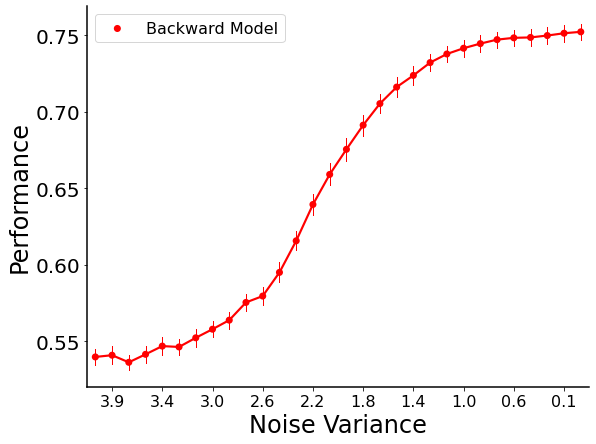

In [76]:
plt.figure(figsize=(9,7))
noise_sub_df = df.groupby(["subject", "noise_var"]).mean(["perf", "metai"]).reset_index()
noise_metai_df = df.groupby(["subject", "noise_var"]).mean("metai").reset_index()

rounded_df = noise_sub_df.round({'noise_var': 1})
rounded_matai_df = noise_metai_df.round({'noise_var': 1})

seaborn.pointplot(data = rounded_df, x= "noise_var", y = "perf", color= "red", errwidth = 1, scale= .8, errorbar = "se", label ="Backward Model")
# seaborn.pointplot(data = rounded_df, x= "noise_var", y = "metai", color= "purple", errwidth = 1, scale= .8, errorbar = "se", label ="Meta_I")

# plt.axhline(fwd_averg_perf, linestyle= "--", label = "Forward Model", color = "blue")

ax = plt.gca()
#hide x-axis
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.add_patch(Rectangle((-1, fwd_averg_perf - se), 100, 2*se, alpha = .1, ls = "", color = "blue"))


plt.gca().invert_xaxis()

plt.xticks(range(1, 30, 3))

plt.xticks(fontsize=16)
plt.yticks(fontsize=20)
plt.legend(fontsize=16)
plt.xlabel("Noise Variance", fontsize = 24)
plt.ylabel("Performance", fontsize = 24)
plt.savefig("across_subs.png".format(subject_id), dpi = 400)

Text(0, 0.5, 'Performance')

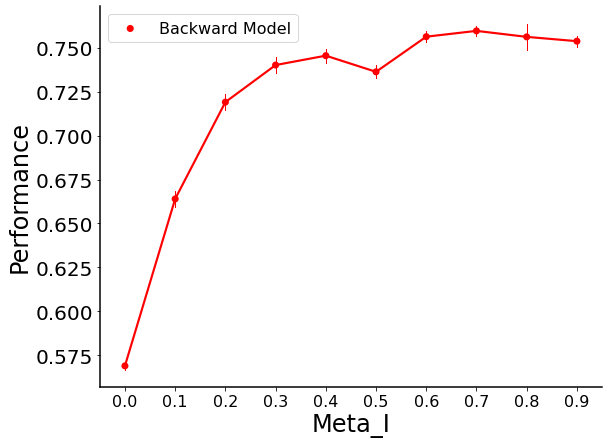

In [74]:
plt.figure(figsize=(9,7))
noise_sub_df = df.groupby(["subject", "noise_var"]).mean(["perf", "metai"]).reset_index()

rounded_df = noise_sub_df.round({'metai': 1})

seaborn.pointplot(data = rounded_df, x= "metai", y = "perf", color= "red", errwidth = 1, scale= .8, errorbar = "se", label ="Backward Model")

# plt.axhline(fwd_averg_perf, linestyle= "--", label = "Forward Model", color = "blue")

ax = plt.gca()
#hide x-axis
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.add_patch(Rectangle((-1, fwd_averg_perf - se), 100, 2*se, alpha = .1, ls = "", color = "blue"))



# plt.xticks(range(1, 30, 3))

plt.xticks(fontsize=16)
plt.yticks(fontsize=20)
plt.legend(fontsize=16)
plt.xlabel("Meta_I", fontsize = 24)
plt.ylabel("Performance", fontsize = 24)

In [31]:
result[0]

(array([0.7275, 0.755 ]), array([0.28639696, 0.28639696]))

In [24]:
seaborn.pointplot(data = noise_df, x= "noise_var", y = "perf", color= "red", errwidth = 1, scale= .8)
plt.axhline(hsyn_forward_simulation_df['cor'].mean(), linestyle= "--", label = "Forward Model", color = "blue")
plt.title("subject_id = {}".format(subject_id))
plt.xticks([])
plt.show()

NameError: name 'noise_df' is not defined

In [ ]:
seaborn.scatterplot(x = noise_vars, y =lsyn_backward_means, color = "red", label = "backward Model")
plt.axhline(hsyn_forward_simulation_df['cor'].mean(), linestyle= "--", label = "Forward Model", color = "blue")
plt.xlabel("Noise Variance", fontsize=14, fontweight='bold')
plt.ylabel("Model Performance", fontsize=14, fontweight='bold')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.show()

In [ ]:
lsyn_backward_means

In [ ]:
low_syn_df

In [ ]:
import random
selected_subs = random.sample(subjects.tolist(), 10)	
selected_subs

In [ ]:
%%time
df_lists= []
count = 0
for i in range(100):
  low_syn_df['cj']= np.random.uniform(1,5, len(high_syn_df))
  params_ranges = [[0, 2], [0, 2], [0, 2], [0, 100], [1,5], [0, 1]]
  n_fitting = 50
  res = fit_for_all_subjects(params_ranges,n_fitting, selected_subs, low_syn_df, backward_fitting)
  lsyn_backward_df = make_df_after_fitting(res, ["alpha_pos", "alpha_neg", "alpha_unchosen", "beta", "lbound", "bound_range"], subjects)
  lsyn_backward_df["hbound"] = (5 - lsyn_backward_df["lbound"])*(lsyn_backward_df["bound_range"]) + lsyn_backward_df["lbound"]
  lsyn_backward_simulation_df = simulate_with_params(lsyn_backward_df, lv_induction_data,subjects)
  lsyn_backward_simulation_df["agent_nr"] = count
  df_lists.append(lsyn_backward_simulation_df)
  count +=1 
agg_df = pd.concat(df_lists, axis=0, ignore_index=True)

In [ ]:
perf_dist = agg_df.groupby(["sub", "agent_nr"]).agg({"cor": "mean"}).reset_index()
perf_dist

In [ ]:
perf_dist[perf_dist['sub'] == subjects[7]]['cor'].hist(bins= 10)

In [ ]:
df_lists_backup = df_lists.copy()

In [ ]:
high_syn_metai = []
low_syn_metai = []
sub_syn_metai = []
for sub in subjects:
    data = high_syn_df[high_syn_df["sub"] == sub].copy()
    metai = calculate_metai(data)
    high_syn_metai.append(metai)
    data = low_syn_df[low_syn_df["sub"] == sub].copy()
    metai = calculate_metai(data)
    low_syn_metai.append(metai)
    data = lv_induction_data[lv_induction_data["sub"] == sub].copy()
    metai = calculate_metai(data)
    sub_syn_metai.append(metai)

In [ ]:
high_metai_df = pd.DataFrame(list(zip(subjects, high_syn_metai)), columns = ["subject", "Meta-I"])
low_metai_df = pd.DataFrame(list(zip(subjects, low_syn_metai)), columns = ["subject", "Meta-I"])
sub_metai_df = pd.DataFrame(list(zip(subjects, sub_syn_metai)), columns = ["subject", "Meta-I"])

groups = ["Empirical", "Low-Meta","High-Meta"]
df = merge_reuslt_df([sub_metai_df, low_metai_df, high_metai_df], groups, 200)
plt.figure(figsize=(8,7))
comparison_plot(df ,"Meta-I", groups, color_dict, "",[["Empirical", "Low-Meta"], ["Low-Meta", "High-Meta"],["Empirical", "High-Meta"]], [1, 1, 1.1], [.01, .01 , .02], y_label="Meta-I")


In [ ]:
def calculate_metai(data):
    data["cj_binned"] = pd.cut(data["cj"], bins=4, labels=False)
    P_rc = data.groupby(["cj_binned","cor"]).count()["trial"]/len(data)
    P_r = data.groupby("cor").count()["trial"]/len(data)
    P_c = data.groupby("cj_binned").count()["trial"]/len(data)
    h2_rc = 0
    for c in P_c.index:
        p_conf = P_rc[c]/sum(P_rc[c])
        h2_conf = sum(-p_conf*np.log2(p_conf))
        h2_rc += P_c[c]*h2_conf
    h2_r = sum(-P_r*np.log2(P_r))
    return h2_r - h2_rc

In [ ]:
meta_i = []
qsr = []
for sub in subjects:
    on_sub_data = lv_induction_data[lv_induction_data["sub"] == sub]
    on_sub_data["cj_binned"] = pd.cut(on_sub_data["cj"], bins=4, labels=False)
    P_rc = on_sub_data.groupby(["cj_binned","cor"]).count()["trial"]/400
    P_r = on_sub_data.groupby("cor").count()["trial"]/400
    P_c = on_sub_data.groupby("cj_binned").count()["trial"]/400
    h2_rc = 0
    for c in P_c.index:
        p_conf = P_rc[c]/sum(P_rc[c])
        h2_conf = sum(-p_conf*np.log2(p_conf))
        h2_rc += P_c[c]*h2_conf
    h2_r = sum(-P_r*np.log2(P_r))
    meta_i.append(h2_r - h2_rc)
    
    cor = on_sub_data["cor"]
    conf = linear_transform_on_array(on_sub_data["cj"], [1, 5], [0, 1])
    qsr.append(1- np.mean(np.power(cor - conf,2)))

In [ ]:
plt.scatter(qsr, meta_i)

In [ ]:
",".join(str(e) for e in meta_i)